# UTMOS Audio Quality Analysis

This notebook demonstrates how to use **UTMOS** (UTokyo-SaruLab Mean Opinion Score) to evaluate speech quality. 

UTMOS is a **non-intrusive** metric, meaning it does not require a reference "clean" audio to predict the quality score. It outputs a value on the MOS scale (typically 1 to 5).

## 1. Installation

You will need `librosa`, `soundfile`, `torch`, and `SpeechMOS`.

In [57]:
# !pip install librosa soundfile torch torchaudio matplotlib
# !pip install git+https://github.com/tarepan/SpeechMOS.git

## 2. Import Libraries

In [58]:
import numpy as np
import librosa
import soundfile as sf
import torch
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings('ignore')

## 3. Utilities for Audio Generation

We'll reuse the synthetic audio generation logic from the PESQ/STOI notebooks but add different types of degradations.

In [59]:
def generate_clean_audio():
    """Load audio from file or generate synthetic audio"""
    filename = "./BAC009S0769W0180.wav"
    audio, sr = sf.read(filename)
    return audio, sr

def add_noise(audio, snr_db=10):
    sig_power = np.mean(audio ** 2)
    noise_power = sig_power / (10 ** (snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), audio.shape)
    return audio + noise

def apply_clipping(audio, threshold=0.1):
    return np.clip(audio, -threshold, threshold)

## 4. Prepare Test Samples

We will evaluate three versions:
1. **Clean**: The baseline synthetic audio.
2. **Noisy**: Clean + Moderate additive noise (15dB SNR).
3. **Clipped**: Clean + Heavy clipping distortion.

In [60]:
ref, sr = generate_clean_audio()

v1 = ref.copy() # Clean
v2 = add_noise(ref, snr_db=15) # Noisy
v3 = apply_clipping(ref, threshold=0.05) # Clipped

samples = {
    "Clean": v1,
    "Noisy (15dB)": v2,
    "Clipped": v3
}

# Save them for verification
for name, data in samples.items():
    sf.write(f"utmos_sample_{name.split()[0].lower()}.wav", data, sr)

## 5. Predict MOS with UTMOS

UTMOS models are loaded via `torch.hub` and expect a PyTorch tensor as input with shape `(Batch, Samples)`.

In [61]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Initializing UTMOS model on {device}...")

# Correct way to load UTMOS predictor using torch.hub
predictor = torch.hub.load('tarepan/SpeechMOS:main', 'utmos22_strong', trust_repo=True)
predictor.to(device)
predictor.eval()

results = {}
for name, audio in samples.items():
    # 1. Convert numpy array to torch tensor
    audio_tensor = torch.from_numpy(audio).to(device, dtype=torch.float32)
    
    # 2. Add batch dimension: (Samples,) -> (1, Samples)
    # This ensures the shape is (Batch, Time), which is expected by SSL-based models
    if audio_tensor.ndim == 1:
        audio_tensor = audio_tensor.unsqueeze(0)
    
    # 3. Predict
    with torch.no_grad():
        score = predictor(audio_tensor, sr)
    
    # 4. Extract scalar value from tensor
    score_value = float(score.item()) if hasattr(score, 'item') else float(score)
    results[name] = score_value
    print(f"[{name}] UTMOS Score: {score_value:.4f}")

Initializing UTMOS model on cpu...


Using cache found in /Users/jiaqiguo/.cache/torch/hub/tarepan_SpeechMOS_main


[Clean] UTMOS Score: 1.6247
[Noisy (15dB)] UTMOS Score: 1.2882
[Clipped] UTMOS Score: 1.4870


## 6. Visualization

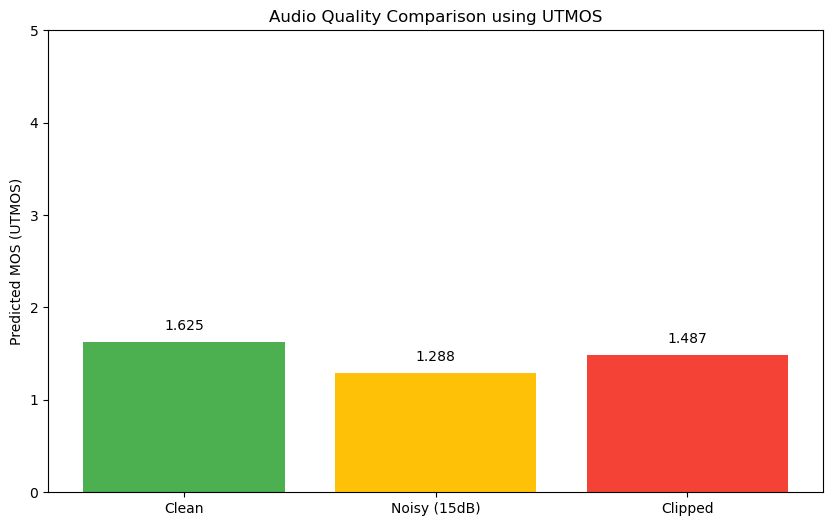

In [62]:
names = list(results.keys())
scores = list(results.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(names, scores, color=['#4CAF50', '#FFC107', '#F44336'])
plt.ylim(0, 5)
plt.ylabel('Predicted MOS (UTMOS)')
plt.title('Audio Quality Comparison using UTMOS')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 3), ha='center', va='bottom')

plt.show()

## 7. Analysis

- **Clean**: Should have the highest score (usually > 3.5 for synthetic speech-like sounds).
- **Noisy**: The score should drop significantly depending on the SNR.
- **Clipped**: Distortion like clipping usually results in very low UTMOS scores as it sounds very unnatural.

### Why use UTMOS over PESQ?
1. **No Reference Needed**: You can evaluate audio recorded in the wild where the clean version is unknown.
2. **Modern Architecture**: It uses a SSL (Self-Supervised Learning) backbone like Wav2Vec 2.0, which captures higher-level features than traditional DSP-based metrics.